In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(100)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop, adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [3]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis = 1)

del train

In [4]:
print("Missing values in training data:", X_train.isnull().sum().any())
print("Missing values in test data:", test.isnull().sum().any())

Missing values in training data: False
Missing values in test data: False


In [5]:
X_train = X_train / 255.0
test = test / 255.0

X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Y_train = to_categorical(Y_train, num_classes = 10)

In [6]:
random_seed = 100
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = random_seed)

In [7]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', 
                 input_shape = (28,28,1), name = "CONV_1"))
model.add(BatchNormalization(name = "BN_1"))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', name = "CONV_2"))
model.add(BatchNormalization(name = "BN_2"))
model.add(MaxPool2D(pool_size=(2,2), name = "MAXPOOL_1"))
model.add(Dropout(0.25, name = "DROP_1"))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu', padding = 'Same', name = "CONV_3"))
model.add(BatchNormalization(name = "BN_3"))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu', padding = 'Same', name = "CONV_4"))
model.add(BatchNormalization(name = "BN_4"))
model.add(MaxPool2D(pool_size=(2,2), name = "MAXPOOL_2"))
model.add(Dropout(0.25, name = "DROP_2"))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu', padding = 'Same', name = "CONV_5"))
model.add(BatchNormalization(name = "BN_5"))
model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu', padding = 'Same', name = "CONV_6"))
model.add(BatchNormalization(name = "BN_6"))
model.add(MaxPool2D(pool_size=(2,2), name = "MAXPOOL_3"))
model.add(Dropout(0.25, name = "DROP_3"))

model.add(Flatten(name = "FLAT_1"))
model.add(Dense(256, activation = "relu", name = "FC_1"))
model.add(BatchNormalization(name = "BN_7"))
model.add(Dropout(0.3, name = "DROP_4"))
model.add(Dense(10, activation = "softmax", name = "FC_2"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 28, 28, 32)        128       
_________________________________________________________________
CONV_2 (Conv2D)              (None, 28, 28, 32)        25632     
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 28, 28, 32)        128       
_________________________________________________________________
MAXPOOL_1 (MaxPooling2D)     (None, 14, 14, 32)        0         
_________________________________________________________________
DROP_1 (Dropout)             (None, 14, 14, 32)        0         
_________________________________________________________________
CONV_3 (Conv2D)              (None, 14, 14, 64)        18496     
__________

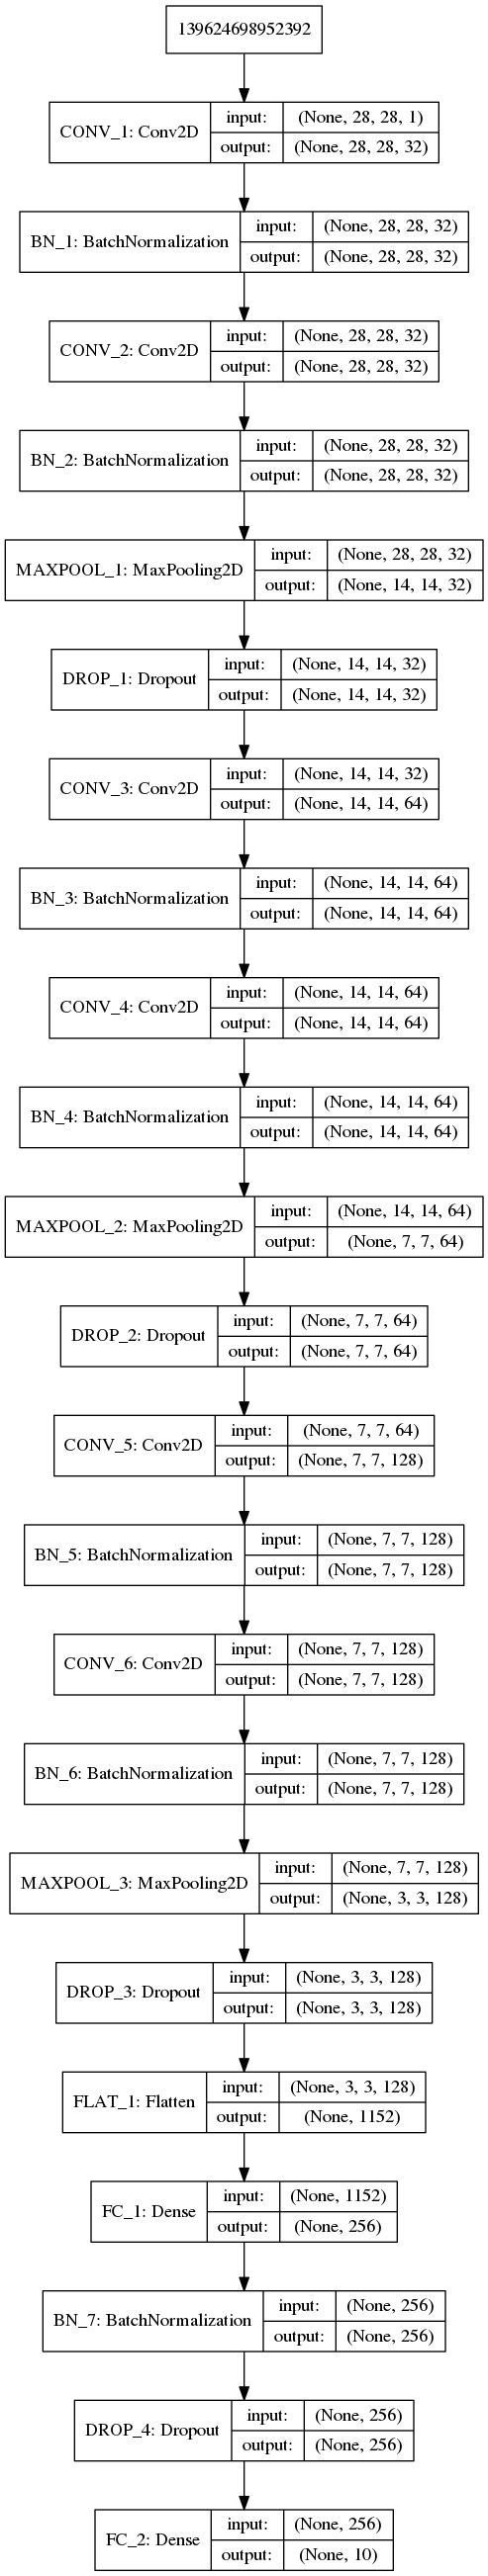

In [8]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

In [9]:
optimizer = RMSprop(lr = 0.001, epsilon = 1e-08, decay = 0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [10]:
callbacks = [
    EarlyStopping(
        monitor = 'val_acc', 
        patience = 10,
        mode = 'max',
        verbose = 1),
    ReduceLROnPlateau(
        monitor = 'val_acc', 
        patience = 3, 
        verbose = 1, 
        factor = 0.5, 
        min_lr = 0.00001)]

In [11]:
epochs = 50
batch_size = 64

In [12]:
datagen = ImageDataGenerator(
        rotation_range = 10, 
        zoom_range = 0.1, 
        width_shift_range = 0.1,  
        height_shift_range = 0.1)  

datagen.fit(X_train)

In [13]:
his = model.fit_generator(datagen.flow(X_train, 
                                 Y_train, 
                                 batch_size = batch_size),
                    epochs = epochs, 
                    validation_data = (X_val,Y_val),
                    verbose = 1, 
                    steps_per_epoch = X_train.shape[0] // batch_size,
                    callbacks = callbacks)

Epoch 1/50
590/590 [==============================] - 21s 36ms/step - loss: 0.2637 - acc: 0.9180 - val_loss: 0.0706 - val_acc: 0.9793
Epoch 2/50
590/590 [==============================] - 18s 31ms/step - loss: 0.0834 - acc: 0.9742 - val_loss: 0.0500 - val_acc: 0.9864
Epoch 3/50
590/590 [==============================] - 18s 30ms/step - loss: 0.0657 - acc: 0.9802 - val_loss: 0.0443 - val_acc: 0.9876
Epoch 4/50
590/590 [==============================] - 18s 31ms/step - loss: 0.0550 - acc: 0.9828 - val_loss: 0.0456 - val_acc: 0.9883
Epoch 5/50
590/590 [==============================] - 19s 31ms/step - loss: 0.0483 - acc: 0.9858 - val_loss: 0.0360 - val_acc: 0.9910
Epoch 6/50
590/590 [==============================] - 18s 31ms/step - loss: 0.0462 - acc: 0.9866 - val_loss: 0.0227 - val_acc: 0.9938
Epoch 7/50
590/590 [==============================] - 18s 31ms/step - loss: 0.0409 - acc: 0.9880 - val_loss: 0.0422 - val_acc: 0.9886
Epoch 8/50
590/590 [==============================] - 18s 31ms

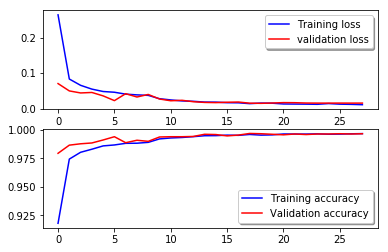

In [14]:
fig, ax = plt.subplots(2,1)
ax[0].plot(his.history['loss'], color = 'b', label = "Training loss")
ax[0].plot(his.history['val_loss'], color = 'r', label = "validation loss" ,axes = ax[0])
legend = ax[0].legend(loc = 'best', shadow = True)

ax[1].plot(his.history['acc'], color = 'b', label = "Training accuracy")
ax[1].plot(his.history['val_acc'], color = 'r',label = "Validation accuracy")
legend = ax[1].legend(loc = 'best', shadow = True)

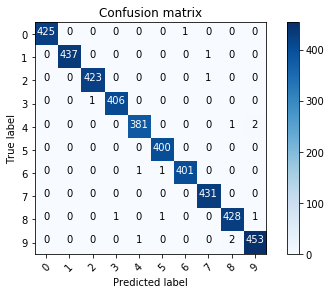

In [15]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

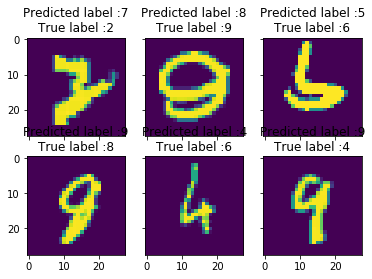

In [16]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error], obs_errors[error]))
            n += 1


Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

most_important_errors = sorted_dela_errors[-6:]
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [17]:
results = model.predict(test)
results = np.argmax(results, axis = 1)
results = pd.Series(results, name = "Label")

In [18]:
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), results], axis = 1)
submission.to_csv("cnn_mnist_datagen5.csv", index = False)